In [78]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = ("cuda" if torch.cuda.is_available() else "cpu")

In [79]:
import cv2
import urllib
import requests
import PIL.Image
import numpy as np
from bs4 import BeautifulSoup

#ship synset
page = requests.get("http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n04194289")
soup = BeautifulSoup(page.content, 'html.parser')
#bicycle synset
bikes_page = requests.get("http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n02834778")
bikes_soup = BeautifulSoup(bikes_page.content, 'html.parser')

str_soup=str(soup)
split_urls=str_soup.split('\r\n')

bikes_str_soup=str(bikes_soup)
bikes_split_urls=bikes_str_soup.split('\r\n')

!mkdir /content/train
!mkdir /content/train/ships
!mkdir /content/train/bikes
!mkdir /content/validation
!mkdir /content/validation/ships
!mkdir /content/validation/bikes

img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)

def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

n_of_training_images=100
for progress in range(n_of_training_images):
    if not split_urls[progress] == None:
        try:
            I = url_to_image(split_urls[progress])
            if (len(I.shape))==3:
                save_path = '/content/train/ships/img'+str(progress)+'.jpg'
                cv2.imwrite(save_path,I)
        except:
            None

for progress in range(n_of_training_images):
    if not bikes_split_urls[progress] == None:
        try:
            I = url_to_image(bikes_split_urls[progress])
            if (len(I.shape))==3:
                save_path = '/content/train/bikes/img'+str(progress)+'.jpg'
                cv2.imwrite(save_path,I)
        except:
            None


for progress in range(50):
    if not split_urls[progress] == None:
        try:
            I = url_to_image(split_urls[n_of_training_images+progress])
            if (len(I.shape))==3:
                save_path = '/content/validation/ships/img'+str(progress)+'.jpg'
                cv2.imwrite(save_path,I)
        except:
            None


for progress in range(50):
    if not bikes_split_urls[progress] == None:
        try:
            I = url_to_image(bikes_split_urls[n_of_training_images+progress])
            if (len(I.shape))==3:
                save_path = '/content/validation/bikes/img'+str(progress)+'.jpg'
                cv2.imwrite(save_path,I)
        except:
            None

mkdir: cannot create directory ‘/content/train’: File exists
mkdir: cannot create directory ‘/content/train/ships’: File exists
mkdir: cannot create directory ‘/content/train/bikes’: File exists
mkdir: cannot create directory ‘/content/validation’: File exists
mkdir: cannot create directory ‘/content/validation/ships’: File exists
mkdir: cannot create directory ‘/content/validation/bikes’: File exists


In [80]:
BATCH_SIZE = 32
EPOCHS = 100
IMG_HEIGHT = 227
IMG_WIDTH  = 227
TRAIN_DIR = "train"
VAL_DIR = "validation"

In [81]:
# Define transform to normalize data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([IMG_HEIGHT, IMG_WIDTH]),
        transforms.RandomRotation(5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize([IMG_HEIGHT, IMG_WIDTH]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

# Download and load the training data
train_set = datasets.ImageFolder(TRAIN_DIR, transform=data_transforms['train'])
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

validation_set = datasets.ImageFolder(VAL_DIR, transform=data_transforms['val'])
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=True)

In [82]:
training_data = iter(trainLoader)
images, labels = training_data.next()
print(type(images)) # Checking the datatype 
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([32, 3, 227, 227])
torch.Size([32])


In [83]:
def imshow_batch(images):
  fig = plt.figure(figsize=(10, 8))
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)
  
  for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)), interpolation='nearest')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


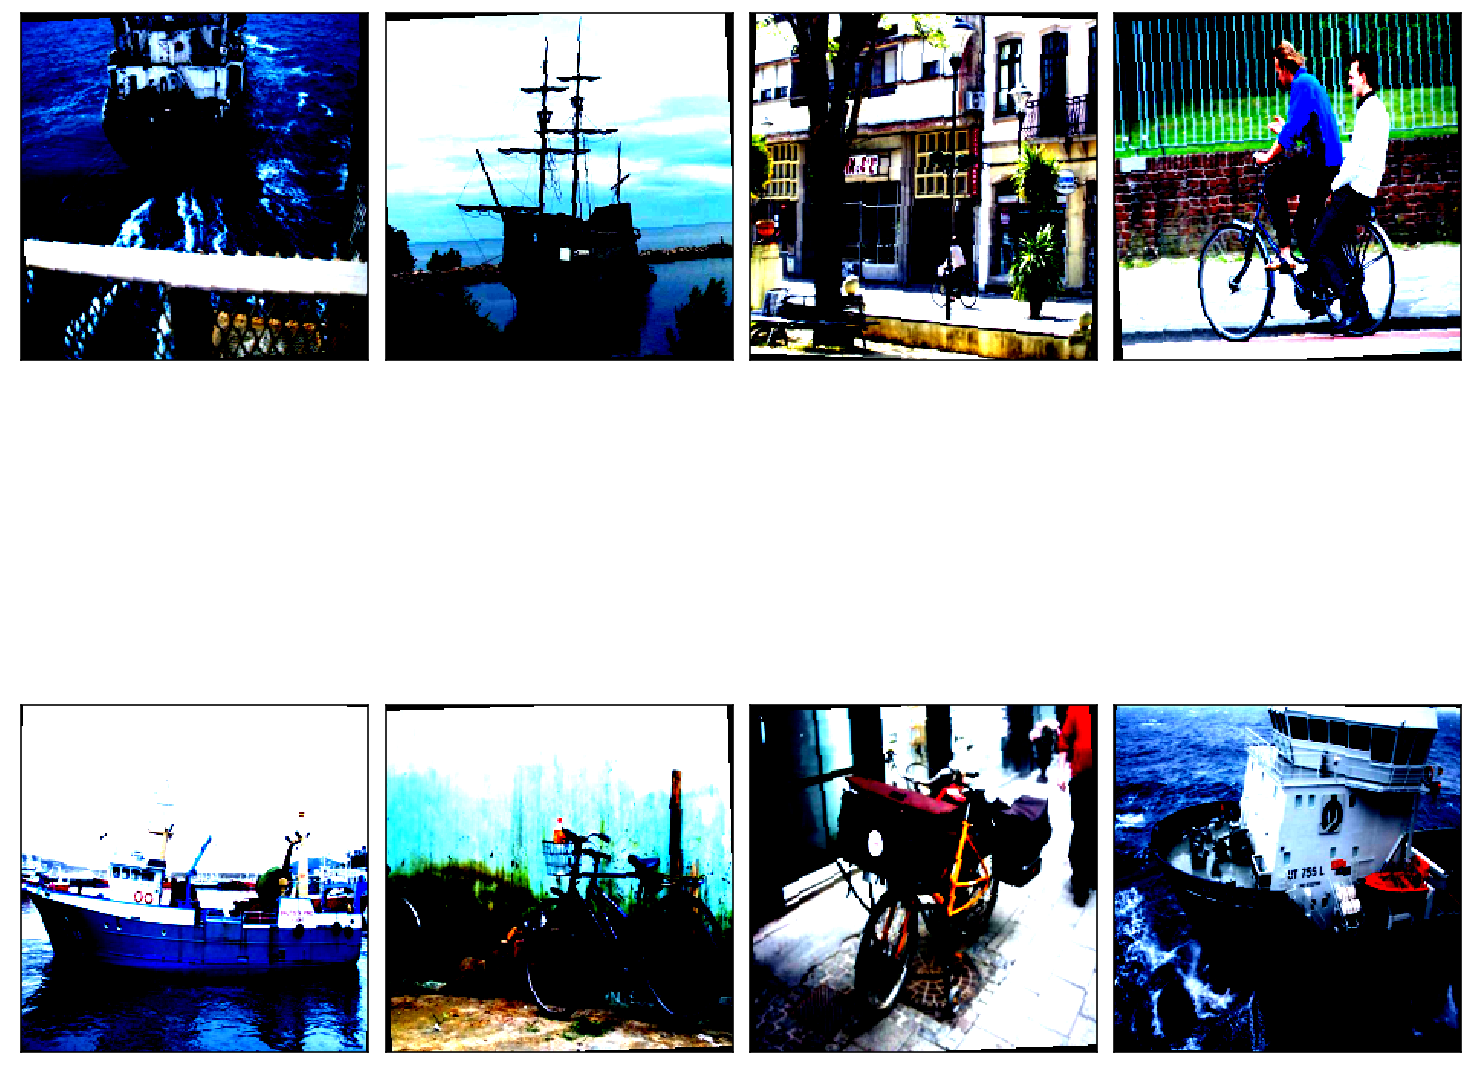

In [84]:
imshow_batch(images)

In [85]:
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.convolutional_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4), # (96 x 55 x 55)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), #(96 x 27 x 27)
            nn.Conv2d(96, 256, 5, padding=2),  # (256 x 27 x 27)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (256 x 13 x 13)
            nn.Conv2d(256, 384, 3, padding=1),  # (384 x 13 x 13)
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, padding=1),  # (384 x 13 x 13)
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1),  # (256 x 13 x 13)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (256 x 6 x 6)
        )

        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=(256*6*6), out_features=4096),
            nn.ReLU(),
            nn.Linear(4096, 1000),
            nn.ReLU(),
            nn.Linear(1000, num_classes)
        )

    def forward(self, x):
        x = self.convolutional_layer(x)
        x = x.view(-1, 256*6*6)
        x = self.linear_layer(x)
        return x

In [95]:
model = AlexNet(num_classes=2)
model.to(device)

AlexNet(
  (convolutional_layer): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=1000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=2, bias=Tru

In [96]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [97]:
epochs = 50
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_test = [], []

for epoch in range(epochs):
   
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    
    total = 0
    # training our model
    for idx, (image, label) in enumerate(trainLoader):

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1
                
    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)
    
    # validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(validationLoader):
        image, label = image.cuda(), label.cuda()
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_test = total / len(validation_set)
    accuracy_total_test.append(accuracy_test)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    if epoch % 5 == 0:
      print("Epoch: {}/{}  ".format(epoch, epochs),
            "Training loss: {:.4f}  ".format(total_train_loss),
            "Testing loss: {:.4f}  ".format(total_val_loss),
            "Train accuracy: {:.4f}  ".format(accuracy_train),
            "Test accuracy: {:.4f}  ".format(accuracy_test))

Epoch: 0/50   Training loss: 4.8803   Testing loss: 0.7246   Train accuracy: 0.5470   Test accuracy: 0.4638  
Epoch: 5/50   Training loss: 0.7660   Testing loss: 0.6776   Train accuracy: 0.5128   Test accuracy: 0.6812  
Epoch: 10/50   Training loss: 0.6622   Testing loss: 0.5919   Train accuracy: 0.5897   Test accuracy: 0.7681  
Epoch: 15/50   Training loss: 0.5799   Testing loss: 0.4736   Train accuracy: 0.7607   Test accuracy: 0.8696  
Epoch: 20/50   Training loss: 0.4388   Testing loss: 0.7873   Train accuracy: 0.7949   Test accuracy: 0.7826  
Epoch: 25/50   Training loss: 0.2840   Testing loss: 0.6085   Train accuracy: 0.8803   Test accuracy: 0.7826  
Epoch: 30/50   Training loss: 0.3213   Testing loss: 0.4565   Train accuracy: 0.8547   Test accuracy: 0.8261  
Epoch: 35/50   Training loss: 0.2376   Testing loss: 1.6925   Train accuracy: 0.9145   Test accuracy: 0.7826  
Epoch: 40/50   Training loss: 0.2709   Testing loss: 0.4024   Train accuracy: 0.8547   Test accuracy: 0.9130  
Epo

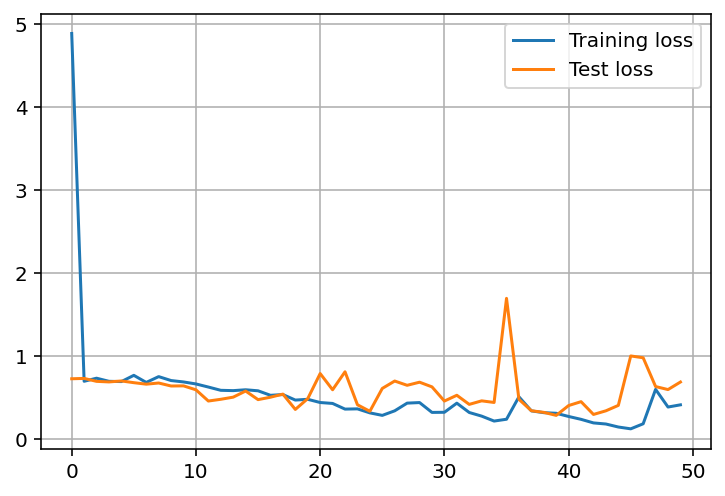

In [98]:
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Test loss')
plt.legend()
plt.grid()

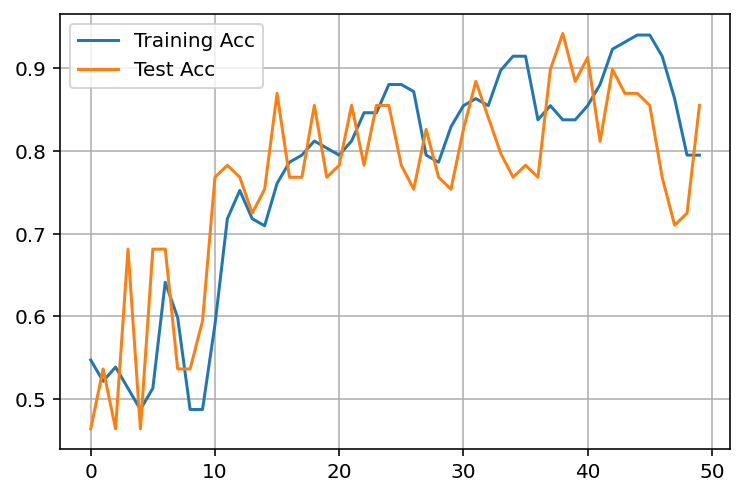

In [99]:
plt.plot(accuracy_total_train, label='Training Acc')
plt.plot(accuracy_total_test, label='Test Acc')
plt.legend()
plt.grid()

In [100]:
images, labels = next(iter(validationLoader))

In [101]:
with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  preds = model(images)

In [102]:
class_names = ['bike', 'boat']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


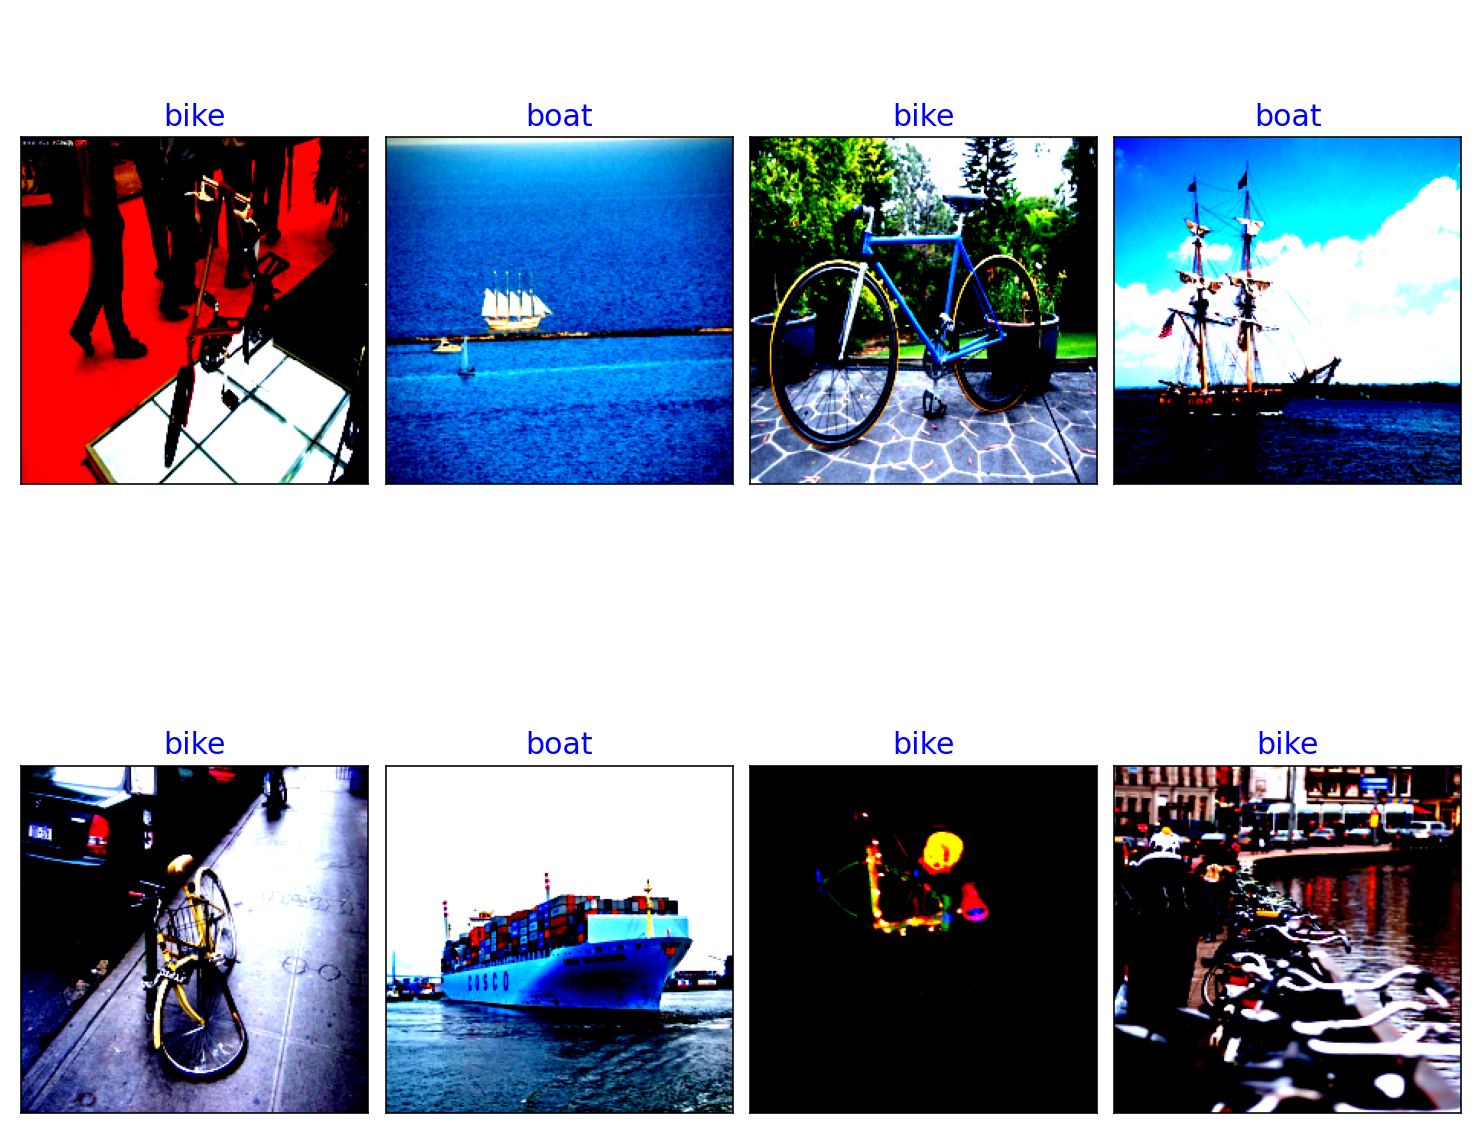

In [103]:
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0, right=1, bottom=-1, top=0, hspace=0.2, wspace=0.05)

for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
    color = "blue" if labels[i] == torch.max(preds[i], 0)[1] else "red"
    plt.title(class_names[torch.max(preds[i], 0)[1]], color=color, fontsize=15)